# Temporal Bathymetry × (CDOM × SST) Analysis - August 2012

This notebook analyzes satellite data for two time periods in August-September 2012 and creates difference maps incorporating indexed bathymetry:

**Time Periods:**
- Period 1: August 24-28, 2012  
- Period 2: August 29 - September 2, 2012

**Data Sources:**
- L2 RRS data: `E:\satdata\Texas Louisiana Shelf_2012-08-24_2012-09-02`
- MUR L4 SST data: `E:\satdata\MUR-JPL-L4-GLOB-v4.1_Texas Louisiana Shelf_2012-08-24_2012-09-02`
- GEBCO Bathymetry: `E:/geodata/gebco_2024_sub_ice_topo/GEBCO_2024_sub_ice_topo.nc`

**Analysis Steps:**
1. Load and process indexed bathymetry data
2. Process CDOM and SST data for each time period
3. Create combined products (Bathymetry × CDOM × SST) for each period
4. Generate difference map (Period 2 - Period 1)

### Indexing Ranges

This analysis uses the same CDOM and SST indexing ranges as `diff_cdomsstv4.ipynb` for consistency:

**CDOM Normalization:**
- Range: 0.015 to 0.06
- Maps to index values 0-1 (higher CDOM = higher index)

**SST Normalization:**
- Range: 25°C to 30°C  
- Maps to index values 0-1 (cooler SST = higher index, warmer SST = lower index)

**Bathymetry Indexing:**
- Range: -30m to -10m depth
- Inverted so shallow water = higher index (emphasizes coastal areas)

### Library Imports and Setup

In [14]:
# Import essential libraries
import glob
import os
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy.stats import binned_statistic_2d
from scipy.interpolate import griddata
import xarray as xr
import matplotlib.colors
import cmocean
from datetime import datetime

import sys
sys.dont_write_bytecode = True
sys.path.append(os.path.abspath(".."))

# Import custom pipeline components
import importlib
from pipelines import l2_pipeline, l3_pipeline
importlib.reload(l2_pipeline)
importlib.reload(l3_pipeline)
from pipelines.l2_pipeline import L2DatasetLoader, GPUDataExtractor, SelectiveInterpolator
from pipelines.l3_pipeline import L3DatasetLoader

# Suppress warnings
import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)
warnings.filterwarnings('ignore', category=UserWarning, module='matplotlib')

### Configuration Parameters

In [15]:
# --- Shared Geographical and Binning Parameters ---
lon_min, lon_max = -95.0, -88.0
lat_min, lat_max = 27.5, 30.5
lat_bins = 200
lon_bins = 300

# --- CDOM Calculation Constants ---
B0 = 0.2487
B1 = 14.028
B2 = 4.085

# --- Data Directories ---
data_dir_l2_rrs = r"E:\satdata\Texas Louisiana Shelf_2012-08-24_2012-09-02"
data_dir_mur_l4 = r"E:\satdata\MUR-JPL-L4-GLOB-v4.1_Texas Louisiana Shelf_2012-08-24_2012-09-02"
bathy_nc_path = r"E:/geodata/gebco_2024_sub_ice_topo/GEBCO_2024_sub_ice_topo.nc"

# --- Processing Parameters ---
rrs_vars_list = ['Rrs_412', 'Rrs_555']
rrs_data_group = 'geophysical_data'
mur_l4_variable = 'analysed_sst'
interpolation_threshold = 128

# --- Bathymetry Parameters ---
min_bathy, max_bathy = -30, -10

print(f"Region: Lon ({lon_min}, {lon_max}), Lat ({lat_min}, {lat_max})")
print(f"Grid: {lat_bins} lat bins, {lon_bins} lon bins")
print(f"L2 RRS Data Directory: {data_dir_l2_rrs}")
print(f"MUR L4 Data Directory: {data_dir_mur_l4}")
print(f"Bathymetry file: {bathy_nc_path}")
print(f"Bathymetry range: {min_bathy}m to {max_bathy}m")

Region: Lon (-95.0, -88.0), Lat (27.5, 30.5)
Grid: 200 lat bins, 300 lon bins
L2 RRS Data Directory: E:\satdata\Texas Louisiana Shelf_2012-08-24_2012-09-02
MUR L4 Data Directory: E:\satdata\MUR-JPL-L4-GLOB-v4.1_Texas Louisiana Shelf_2012-08-24_2012-09-02
Bathymetry file: E:/geodata/gebco_2024_sub_ice_topo/GEBCO_2024_sub_ice_topo.nc
Bathymetry range: -30m to -10m


In [16]:
# --- Indexing Ranges (matching diff_cdomsstv4.ipynb) ---
sst_min, sst_max = 25, 30  # SST indexing range in Celsius
cdom_min, cdom_max = 0.015, 0.06  # CDOM indexing range

print(f"SST indexing range: {sst_min}°C to {sst_max}°C")
print(f"CDOM indexing range: {cdom_min} to {cdom_max}")
print("These ranges match those used in diff_cdomsstv4.ipynb for consistency")

SST indexing range: 25°C to 30°C
CDOM indexing range: 0.015 to 0.06
These ranges match those used in diff_cdomsstv4.ipynb for consistency


### Time Period Definitions

In [17]:
# Define time periods
period1_start = datetime(2012, 8, 24)
period1_end = datetime(2012, 8, 28)
period2_start = datetime(2012, 8, 29)
period2_end = datetime(2012, 9, 2)

print(f"Period 1: {period1_start.strftime('%Y-%m-%d')} to {period1_end.strftime('%Y-%m-%d')}")
print(f"Period 2: {period2_start.strftime('%Y-%m-%d')} to {period2_end.strftime('%Y-%m-%d')}")

Period 1: 2012-08-24 to 2012-08-28
Period 2: 2012-08-29 to 2012-09-02


### Utility Functions

In [18]:
def filter_files_by_date_range(file_list, start_date, end_date):
    """Filter files based on date range in filename"""
    filtered_files = []
    for file_path in file_list:
        filename = os.path.basename(file_path)
        # Extract date from filename (assuming format with date like 20120824)
        try:
            if 'A2012' in filename:  # MODIS Aqua format
                date_str = filename.split('A2012')[1][:3]  # Day of year
                file_date = datetime.strptime(f'2012{date_str}', '%Y%j')
            else:
                # Try to find date pattern YYYYMMDD
                import re
                date_match = re.search(r'(2012\d{4})', filename)
                if date_match:
                    file_date = datetime.strptime(date_match.group(1), '%Y%m%d')
                else:
                    continue
            
            if start_date <= file_date <= end_date:
                filtered_files.append(file_path)
        except:
            continue
    return filtered_files

def index_sst_maps(data_array, sst_min, sst_max):
    """Normalize SST data to 0-1 range"""
    original_nans = np.isnan(data_array)
    indexed = (sst_max - data_array) / (sst_max - sst_min)
    indexed = np.clip(indexed, 0, 1)
    indexed[original_nans] = np.nan
    return indexed

def normalize_cdom_custom(data_array, cdom_min=0.01, cdom_max=0.16):
    """Normalize CDOM data to 0-1 range"""
    clamped_data = np.clip(data_array, cdom_min, cdom_max)
    normalized_array = (clamped_data - cdom_min) / (cdom_max - cdom_min)
    normalized_array[np.isnan(data_array)] = np.nan
    return normalized_array

def get_bin_edges_from_centers(centers):
    """Convert bin centers to bin edges"""
    diffs = np.diff(centers)
    edges = np.concatenate(([centers[0] - diffs[0]/2],
                           centers[:-1] + diffs/2,
                           [centers[-1] + diffs[-1]/2]))
    return edges

print("Utility functions loaded successfully.")

Utility functions loaded successfully.


### Load and Process Bathymetry Data

In [19]:
# --- Load GEBCO Bathymetry Data ---
print("Loading bathymetry data...")
ds_bathy = xr.open_dataset(bathy_nc_path)

# Subset bathymetry to the same region as the analysis
bathy_subset = ds_bathy.sel(lon=slice(lon_min, lon_max), lat=slice(lat_min, lat_max))

# GEBCO bathymetry variable is usually called 'elevation' or 'z', check which exists
bathy_var = None
for v in ['elevation', 'z', 'bathymetry']:
    if v in bathy_subset.variables:
        bathy_var = v
        break
        
if bathy_var is None:
    raise ValueError('No bathymetry variable found in GEBCO file.')

bathy = bathy_subset[bathy_var].values
bathy_lats = bathy_subset['lat'].values
bathy_lons = bathy_subset['lon'].values

print(f"Bathymetry data loaded. Shape: {bathy.shape}")
print(f"Bathymetry range: {np.nanmin(bathy):.1f}m to {np.nanmax(bathy):.1f}m")

Loading bathymetry data...
Bathymetry data loaded. Shape: (720, 1680)
Bathymetry range: -2647.0m to 77.0m


In [20]:
# --- Index and invert bathymetry ---
indexed_bathymetry = np.zeros_like(bathy, dtype=np.float32)
mask = (bathy >= min_bathy) & (bathy <= max_bathy)
indexed_bathymetry[mask] = (bathy[mask] - min_bathy) / (max_bathy - min_bathy)
indexed_bathymetry[bathy > max_bathy] = 1.0
indexed_bathymetry_inverted = 1.0 - indexed_bathymetry

print(f"Indexed bathymetry range: {np.nanmin(indexed_bathymetry_inverted):.4f} to {np.nanmax(indexed_bathymetry_inverted):.4f}")
print(f"Non-zero bathymetry points: {np.sum(indexed_bathymetry_inverted > 0)}")

Indexed bathymetry range: 0.0000 to 1.0000
Non-zero bathymetry points: 739041


### Data Processing Function

In [21]:
def process_period_data(l2_files, mur_files, period_name):
    """Process CDOM and SST data for a specific time period and combine with bathymetry"""
    print(f"\n=== Processing {period_name} ===")
    
    # Process CDOM data
    print(f"Processing {len(l2_files)} L2 RRS files for CDOM...")
    
    # Load L2 datasets
    loader_rrs = L2DatasetLoader(variables=rrs_vars_list, group=rrs_data_group)
    datasets_rrs = loader_rrs.load_multiple(l2_files)
    print(f"Loaded {len(datasets_rrs)} L2 RRS datasets")
    
    # Extract L2 data
    extractor_rrs = GPUDataExtractor(variables=rrs_vars_list)
    lon_rrs_flat, lat_rrs_flat, rrs_vars_data_flat = extractor_rrs.extract(datasets_rrs)
    print(f"Extracted {len(lon_rrs_flat)} L2 RRS data points")
    
    # Calculate CDOM
    Rss412 = rrs_vars_data_flat.get(rrs_vars_list[0], np.array([]))
    Rss555 = rrs_vars_data_flat.get(rrs_vars_list[1], np.array([]))
    
    if Rss412.size > 0 and Rss555.size > 0:
        term_ratio = Rss412 / Rss555
        term_numerator = term_ratio - B0
        term_division = term_numerator / B2
        valid_log_mask = term_division > 0
        
        cdom_values = np.full_like(term_division, np.nan)
        if np.any(valid_log_mask):
            cdom_values[valid_log_mask] = (np.log(term_division[valid_log_mask])) / (-B1)
        
        print(f"CDOM calculation complete. Range: {np.nanmin(cdom_values):.4f} to {np.nanmax(cdom_values):.4f}")
        
        # Filter valid CDOM data
        valid_mask = ~np.isnan(lon_rrs_flat) & ~np.isnan(lat_rrs_flat) & ~np.isnan(cdom_values)
        final_lon_cdom = lon_rrs_flat[valid_mask]
        final_lat_cdom = lat_rrs_flat[valid_mask]
        final_cdom_raw = cdom_values[valid_mask]
        
        # Clip to bounding box
        clip_mask = (
            (final_lon_cdom >= lon_min) & (final_lon_cdom <= lon_max) &
            (final_lat_cdom >= lat_min) & (final_lat_cdom <= lat_max)
        )
        clipped_lon_cdom = final_lon_cdom[clip_mask]
        clipped_lat_cdom = final_lat_cdom[clip_mask]
        clipped_cdom_raw = final_cdom_raw[clip_mask]
        
        # Bin CDOM data
        if clipped_lon_cdom.size > 0:
            binned_cdom_raw, lat_edges, lon_edges, _ = binned_statistic_2d(
                clipped_lat_cdom, clipped_lon_cdom, clipped_cdom_raw,
                statistic='mean', bins=[lat_bins, lon_bins],
                range=[[lat_min, lat_max], [lon_min, lon_max]]
            )
            
            # Interpolate NaNs
            binned_cdom_interpolated = SelectiveInterpolator.interpolate(
                binned_cdom_raw, lat_edges, lon_edges, threshold=interpolation_threshold
            )
        else:
            binned_cdom_interpolated = np.full((lat_bins, lon_bins), np.nan)
            lat_edges = np.linspace(lat_min, lat_max, lat_bins + 1)
            lon_edges = np.linspace(lon_min, lon_max, lon_bins + 1)
    else:
        binned_cdom_interpolated = np.full((lat_bins, lon_bins), np.nan)
        lat_edges = np.linspace(lat_min, lat_max, lat_bins + 1)
        lon_edges = np.linspace(lon_min, lon_max, lon_bins + 1)
    
    # Process SST data
    print(f"Processing {len(mur_files)} MUR L4 SST files...")
    
    l3_loader = L3DatasetLoader(variables=[mur_l4_variable], bbox=(lon_min, lon_max, lat_min, lat_max))
    mur_l4_datasets = l3_loader.load_multiple(mur_files)
    
    if mur_l4_datasets:
        # Combine multiple SST datasets by averaging
        sst_combined = None
        sst_lat = None
        sst_lon = None
        
        for ds in mur_l4_datasets:
            sst_data = ds[mur_l4_variable].values
            if sst_combined is None:
                sst_combined = sst_data
                sst_lat = ds['lat'].values
                sst_lon = ds['lon'].values
            else:
                # Average with existing data (handling NaNs)
                sst_combined = np.nanmean([sst_combined, sst_data], axis=0)
        
        # Convert from Kelvin to Celsius
        sst_celsius = sst_combined - 273.15
        print(f"SST data processed. Range: {np.nanmin(sst_celsius):.2f}°C to {np.nanmax(sst_celsius):.2f}°C")
    else:
        sst_celsius = np.full((lat_bins, lon_bins), np.nan)
        sst_lat = np.linspace(lat_min, lat_max, lat_bins)
        sst_lon = np.linspace(lon_min, lon_max, lon_bins)
        print("No valid SST data loaded")
    
    # Interpolate CDOM to SST grid if needed
    if binned_cdom_interpolated.shape != sst_celsius.shape:
        cdom_lat_centers = (lat_edges[:-1] + lat_edges[1:]) / 2
        cdom_lon_centers = (lon_edges[:-1] + lon_edges[1:]) / 2
        cdom_lon_mesh, cdom_lat_mesh = np.meshgrid(cdom_lon_centers, cdom_lat_centers)
        
        if sst_lat.ndim == 1 and sst_lon.ndim == 1:
            sst_lon_mesh, sst_lat_mesh = np.meshgrid(sst_lon, sst_lat)
        else:
            sst_lat_mesh, sst_lon_mesh = sst_lat, sst_lon
        
        cdom_interp = griddata(
            (cdom_lat_mesh.flatten(), cdom_lon_mesh.flatten()),
            binned_cdom_interpolated.flatten(),
            (sst_lat_mesh, sst_lon_mesh),
            method='linear',
            fill_value=np.nan
        )
    else:
        cdom_interp = binned_cdom_interpolated
    
    # Normalize data using the same ranges as diff_cdomsstv4
    sst_indexed = index_sst_maps(sst_celsius, sst_min=25, sst_max=30)
    cdom_normalized = normalize_cdom_custom(cdom_interp, cdom_min=0.015, cdom_max=0.06)
    
    # Interpolate bathymetry to SST grid
    if sst_lat.ndim == 1 and sst_lon.ndim == 1:
        target_lon_mesh, target_lat_mesh = np.meshgrid(sst_lon, sst_lat)
    else:
        target_lat_mesh, target_lon_mesh = sst_lat, sst_lon
    
    bathy_lon_mesh, bathy_lat_mesh = np.meshgrid(bathy_lons, bathy_lats)
    
    bathy_interp = griddata(
        (bathy_lat_mesh.flatten(), bathy_lon_mesh.flatten()),
        indexed_bathymetry_inverted.flatten(),
        (target_lat_mesh, target_lon_mesh),
        method='nearest',
        fill_value=np.nan
    )
    
    # Create combined product: Bathymetry × CDOM × SST
    combined_product = bathy_interp * cdom_normalized * sst_indexed
    
    print(f"Combined product range: {np.nanmin(combined_product):.4f} to {np.nanmax(combined_product):.4f}")
    print(f"Valid data points: {np.sum(~np.isnan(combined_product))}")
    
    return combined_product, sst_lat, sst_lon

print("Data processing function defined.")

Data processing function defined.


### File Discovery and Filtering

In [22]:
# Find all available files
all_l2_files = glob.glob(os.path.join(data_dir_l2_rrs, '**', '*.nc'), recursive=True)
all_mur_files = glob.glob(os.path.join(data_dir_mur_l4, '*.nc'))

print(f"Found {len(all_l2_files)} total L2 RRS files")
print(f"Found {len(all_mur_files)} total MUR L4 files")

# Filter files by time periods
period1_l2_files = filter_files_by_date_range(all_l2_files, period1_start, period1_end)
period1_mur_files = filter_files_by_date_range(all_mur_files, period1_start, period1_end)

period2_l2_files = filter_files_by_date_range(all_l2_files, period2_start, period2_end)
period2_mur_files = filter_files_by_date_range(all_mur_files, period2_start, period2_end)

print(f"\nPeriod 1 files:")
print(f"  L2 RRS: {len(period1_l2_files)} files")
print(f"  MUR L4: {len(period1_mur_files)} files")

print(f"\nPeriod 2 files:")
print(f"  L2 RRS: {len(period2_l2_files)} files")
print(f"  MUR L4: {len(period2_mur_files)} files")

Found 15 total L2 RRS files
Found 11 total MUR L4 files

Period 1 files:
  L2 RRS: 8 files
  MUR L4: 5 files

Period 2 files:
  L2 RRS: 7 files
  MUR L4: 5 files


### Process Period 1 Data

In [23]:
period1_combined, grid_lat, grid_lon = process_period_data(
    period1_l2_files, period1_mur_files, "Period 1 (Aug 24-28, 2012)"
)


=== Processing Period 1 (Aug 24-28, 2012) ===
Processing 8 L2 RRS files for CDOM...
Loaded 8 L2 RRS datasets
Loaded 8 L2 RRS datasets
Extracted 2052727 L2 RRS data points
CDOM calculation complete. Range: -inf to 0.9355
Extracted 2052727 L2 RRS data points
CDOM calculation complete. Range: -inf to 0.9355
Processing 5 MUR L4 SST files...
SST data processed. Range: 28.38°C to 30.67°C
Processing 5 MUR L4 SST files...
SST data processed. Range: 28.38°C to 30.67°C
Combined product range: 0.0000 to 0.2541
Valid data points: 107046
Combined product range: 0.0000 to 0.2541
Valid data points: 107046


### Process Period 2 Data

In [24]:
period2_combined, _, _ = process_period_data(
    period2_l2_files, period2_mur_files, "Period 2 (Aug 29 - Sep 2, 2012)"
)


=== Processing Period 2 (Aug 29 - Sep 2, 2012) ===
Processing 7 L2 RRS files for CDOM...
Loaded 7 L2 RRS datasets
Loaded 7 L2 RRS datasets
Extracted 2989407 L2 RRS data points
CDOM calculation complete. Range: -inf to 1.1034
Extracted 2989407 L2 RRS data points
CDOM calculation complete. Range: -inf to 1.1034
Processing 5 MUR L4 SST files...
SST data processed. Range: 27.75°C to 30.27°C
Processing 5 MUR L4 SST files...
SST data processed. Range: 27.75°C to 30.27°C
Combined product range: 0.0000 to 0.4328
Valid data points: 116385
Combined product range: 0.0000 to 0.4328
Valid data points: 116385


### Calculate Difference and Create Plots

In [25]:
# Calculate difference (Period 2 - Period 1)
difference_map = period2_combined - period1_combined

print(f"\nDifference statistics:")
print(f"  Range: {np.nanmin(difference_map):.4f} to {np.nanmax(difference_map):.4f}")
print(f"  Mean: {np.nanmean(difference_map):.4f}")
print(f"  Std: {np.nanstd(difference_map):.4f}")
print(f"  Valid pixels: {np.sum(~np.isnan(difference_map))}")


Difference statistics:
  Range: -0.1356 to 0.3611
  Mean: 0.0392
  Std: 0.0770
  Valid pixels: 86604


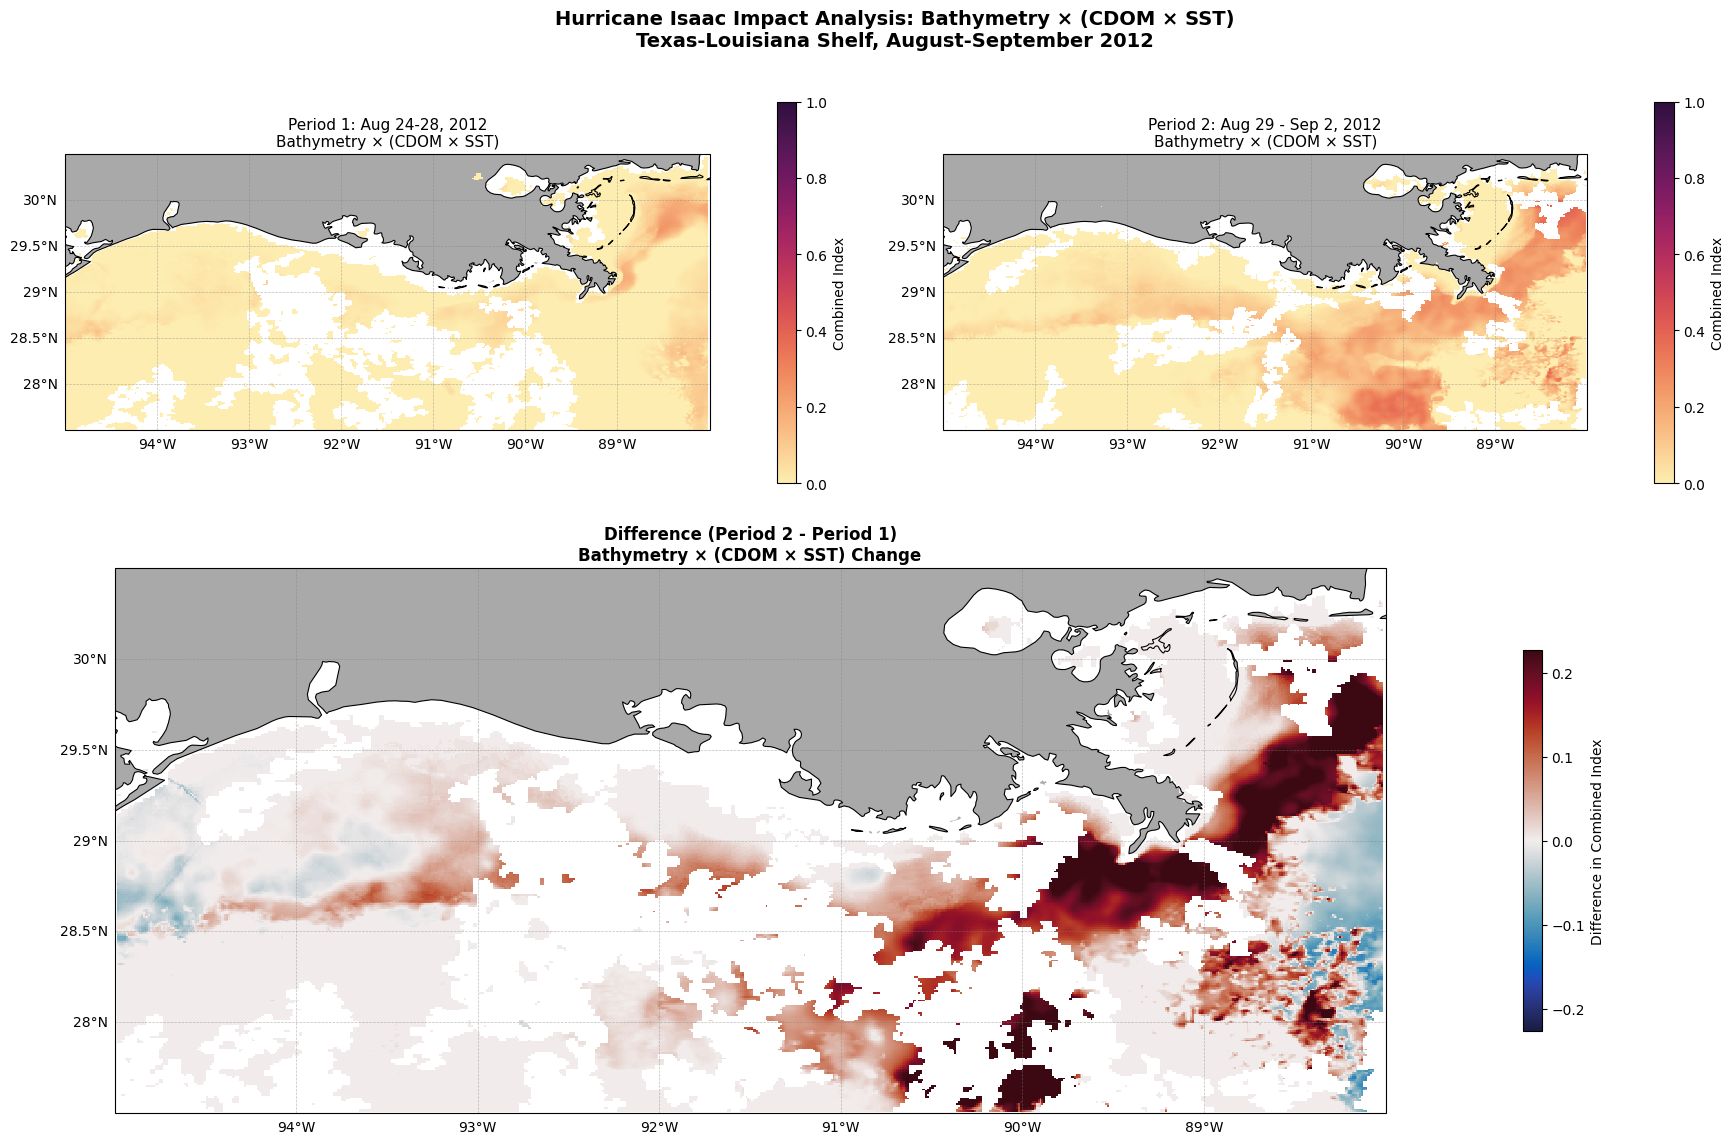


Analysis complete! The difference map shows the change in the combined bathymetry-weighted CDOM×SST index.
Positive values (red) indicate increases, negative values (blue) indicate decreases.


In [26]:
# Prepare grid edges for plotting
if grid_lat.ndim == 1 and grid_lon.ndim == 1:
    lat_edges = get_bin_edges_from_centers(grid_lat)
    lon_edges = get_bin_edges_from_centers(grid_lon)
else:
    lat_edges = grid_lat
    lon_edges = grid_lon

# Create comprehensive plot
fig = plt.figure(figsize=(18, 12))

# Plot Period 1
ax1 = plt.subplot(2, 2, 1, projection=ccrs.PlateCarree())
ax1.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

p1 = ax1.pcolormesh(lon_edges, lat_edges, np.squeeze(period1_combined),
                   cmap=cmocean.cm.matter, shading='auto',
                   vmin=0, vmax=1, transform=ccrs.PlateCarree())

ax1.add_feature(cfeature.COASTLINE, linewidth=0.8, edgecolor='black', zorder=3)
ax1.add_feature(cfeature.LAND, facecolor='darkgray', zorder=0)
ax1.add_feature(cfeature.BORDERS, linestyle=':', edgecolor='dimgray', zorder=2)

gl1 = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl1.top_labels = False
gl1.right_labels = False

ax1.set_title('Period 1: Aug 24-28, 2012\nBathymetry × (CDOM × SST)', fontsize=11)
cbar1 = fig.colorbar(p1, ax=ax1, label='Combined Index', shrink=0.7, pad=0.08)

# Plot Period 2
ax2 = plt.subplot(2, 2, 2, projection=ccrs.PlateCarree())
ax2.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

p2 = ax2.pcolormesh(lon_edges, lat_edges, np.squeeze(period2_combined),
                   cmap=cmocean.cm.matter, shading='auto',
                   vmin=0, vmax=1, transform=ccrs.PlateCarree())

ax2.add_feature(cfeature.COASTLINE, linewidth=0.8, edgecolor='black', zorder=3)
ax2.add_feature(cfeature.LAND, facecolor='darkgray', zorder=0)
ax2.add_feature(cfeature.BORDERS, linestyle=':', edgecolor='dimgray', zorder=2)

gl2 = ax2.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl2.top_labels = False
gl2.right_labels = False

ax2.set_title('Period 2: Aug 29 - Sep 2, 2012\nBathymetry × (CDOM × SST)', fontsize=11)
cbar2 = fig.colorbar(p2, ax=ax2, label='Combined Index', shrink=0.7, pad=0.08)

# Plot Difference
ax3 = plt.subplot(2, 1, 2, projection=ccrs.PlateCarree())
ax3.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

# Use symmetric colormap for difference
diff_max = np.max(np.abs(np.nanpercentile(difference_map, [5, 95])))
diff_max = max(diff_max, 0.1)  # Ensure minimum range

p3 = ax3.pcolormesh(lon_edges, lat_edges, np.squeeze(difference_map),
                   cmap=cmocean.cm.balance, shading='auto',
                   vmin=-diff_max, vmax=diff_max, transform=ccrs.PlateCarree())

ax3.add_feature(cfeature.COASTLINE, linewidth=0.8, edgecolor='black', zorder=3)
ax3.add_feature(cfeature.LAND, facecolor='darkgray', zorder=0)
ax3.add_feature(cfeature.BORDERS, linestyle=':', edgecolor='dimgray', zorder=2)

gl3 = ax3.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl3.top_labels = False
gl3.right_labels = False

ax3.set_title('Difference (Period 2 - Period 1)\nBathymetry × (CDOM × SST) Change', fontsize=12, fontweight='bold')
cbar3 = fig.colorbar(p3, ax=ax3, label='Difference in Combined Index', shrink=0.7, pad=0.08)

plt.suptitle('Hurricane Isaac Impact Analysis: Bathymetry × (CDOM × SST)\nTexas-Louisiana Shelf, August-September 2012', 
            fontsize=14, fontweight='bold', y=0.95)

plt.tight_layout()
plt.show()

print("\nAnalysis complete! The difference map shows the change in the combined bathymetry-weighted CDOM×SST index.")
print("Positive values (red) indicate increases, negative values (blue) indicate decreases.")